In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns

from keras.models import Model, load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score, f1_score

from sys import path
path.append(".."); from generate_patients import Patient

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../patients.obj', 'rb') as patients_file:
    patients = pickle.load(patients_file)
print('Number of patients: %s' % len(patients))

valid_patients = [patient for patient in patients if patient.features[10] >= 0]  # Remove excluded patients
print('Number of non-excluded patients: %s' % len(valid_patients))

Number of patients: 79
Number of non-excluded patients: 73


In [4]:
data   = [patient.spectrogram_whole for patient in valid_patients]
labels = [int(patient.features[10]) for patient in valid_patients]

data_train, data_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, stratify=labels)
print('Training set:', len(data_train), '\tTest set:', len(data_test))

Training set: 54 	Test set: 19


In [5]:
specgrams_train, specgrams_test = [], []
for specgram in data_train:
    start = specgram[:,:68]  # Beginning of the spectrogram
    end = specgram[:,-68:]   # End of the spectrogram
        
    specgrams_train.append(start)
    specgrams_train.append(np.flip(start, 0))       # flip rows / y axis
    specgrams_train.append(np.flip(start, 1))       # flip columns / x axis
    specgrams_train.append(np.flip(start, (0, 1)))  # flip rows and columns / x and y axis
    
    specgrams_train.append(end)
    specgrams_train.append(np.flip(end, 0))       # flip rows / y axis
    specgrams_train.append(np.flip(end, 1))       # flip columns / x axis
    specgrams_train.append(np.flip(end, (0, 1)))  # flip rows and columns / x and y axis

for specgram in data_test:
    specgrams_test.append(specgram[:,:68])   # Beginning of the spectrogram
    specgrams_test.append(specgram[:,-68:])  # End of the spectrogram

y_train = [label for label in y_train for _ in range(8)]
y_test = [label for label in y_test for _ in range(2)]
print('Training set:', len(specgrams_train), '\tTest set:', len(specgrams_test))

Training set: 432 	Test set: 38


## Load 544 features autoencoder model and extract encoder layers

In [6]:
autoencoder = load_model('../Autoencoders/best_model_544.h5')

encoder = Model(autoencoder.layers[0].input, autoencoder.layers[8].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 68, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 8)         6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 34, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 8)         0         
__________

### Extract features from spectrograms and normalize

In [7]:
scaler = StandardScaler()

reshape = np.reshape(specgrams_train, (len(specgrams_train), specgrams_train[0].shape[0], specgrams_train[0].shape[1], 1))
features_train = encoder.predict([reshape])
features_norm_train = scaler.fit_transform(features_train)
print('Before Scaling:\t Max: %s\tMin: %s\nAfter Scaling:\t Max: %s\tMin: %s' % (np.min(features_train), np.max(features_train), np.min(features_norm_train), np.max(features_norm_train)))

Before Scaling:	 Max: 0.0	Min: 89.398544
After Scaling:	 Max: -2.9903033	Min: 19.177235


In [8]:
reshape = np.reshape(specgrams_test, (len(specgrams_test), specgrams_test[0].shape[0], specgrams_test[0].shape[1], 1))
features_test = encoder.predict([reshape])
features_norm_test = scaler.transform(features_test)
print('Before Scaling:\t Max: %s\tMin: %s\nAfter Scaling:\t Max: %s\tMin: %s' % (np.min(features_test), np.max(features_test), np.min(features_norm_test), np.max(features_norm_test)))

Before Scaling:	 Max: 0.0	Min: 68.092354
After Scaling:	 Max: -2.9903033	Min: 20.600403


### Analyze PCA cumulative variance

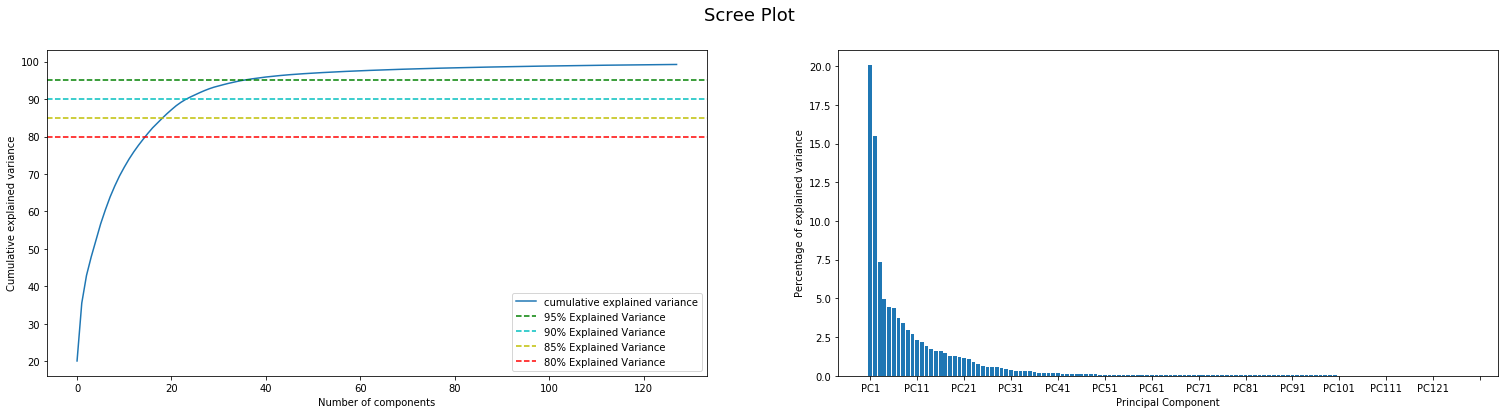

In [9]:
pca = PCA(n_components=128)
pca.fit(features_norm_train)
explained_variance = pca.explained_variance_ratio_*100

plt.subplot(121)
plt.plot(np.cumsum(explained_variance), label='cumulative explained variance')
plt.axhline(y = 95, color='g', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='y', linestyle='--', label = '85% Explained Variance')
plt.axhline(y = 80, color='r', linestyle='--', label = '80% Explained Variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend(loc='best')

plt.subplot(122).get_xaxis().set_major_locator(plt.MaxNLocator(16))
plt.bar(['PC%s' % i for i in range(1, len(explained_variance)+1)], explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of explained variance')

plt.suptitle('Scree Plot', fontsize=18)
plt.show()

### Define Classifier Objects, Parameter Grid Variables and Number of PCA Components

In [10]:
rf_classifier = (RandomForestClassifier(class_weight='balanced') for i in iter(int, 1))
rf_parameter_grid = {'n_estimators':[50, 100, 200, 400], 'max_depth':[20, 40, 80, 120], 'max_features':['sqrt', 'log2']}

svc_classifier = (SVC(probability=True, class_weight='balanced') for i in iter(int, 1))
svc_parameter_grid = [{'kernel': ['rbf'],  'gamma': [1e-5, 1e-4, 0.0005, 1e-3, 0.005, 1e-2], 'C': [0.1, 1, 5, 10, 50, 100]},
                      {'kernel': ['poly'], 'gamma': [1e-5, 1e-4, 0.0005, 1e-3, 0.005, 1e-2], 'C': [0.1, 1, 5, 10, 50, 100], 'degree': [2, 3]}]

gb_classifier = (GradientBoostingClassifier() for i in iter(int, 1))
gb_parameter_grid = {'n_estimators': [40, 60, 80], 'max_depth': [4, 8, 12, 16, 20], 'max_features':['log2', 'sqrt'], 'learning_rate': [0.05, 0.1, 0.2]}

adab_classifier = (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced')) for i in iter(int, 1))
adab_parameter_grid = {'n_estimators': [50, 100, 200], 'learning_rate' : [0.1, 0.5, 1], 'base_estimator__max_depth': [1, 2, 4]}

pca_components = [64, 32, 16]
classifiers = [(rf_classifier, rf_parameter_grid, 'RandomForest'), (svc_classifier, svc_parameter_grid, 'SVM'),
               (gb_classifier, gb_parameter_grid, 'GradientBoosting'), (adab_classifier, adab_parameter_grid, 'AdaBoosting')]

In [11]:
# pca = PCA(n_components=64)
# X_train = pca.fit_transform(features_norm_train)
# X_test = pca.transform(features_norm_test)
# print('PCA Explained Variance:', sum(pca.explained_variance_ratio_))

# classifier = svc_classifier
# parameters = svc_parameter_grid

# grid_search = GridSearchCV(next(classifier), param_grid=parameters, cv=StratifiedKFold(n_splits=4), scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print('Best parameters: %s' % grid_search.best_params_)
# print('Best mean score: %s' % grid_search.best_score_)
# print('Standard Deviation: %s\n' % grid_search.cv_results_['std_test_score'][np.argmin(grid_search.cv_results_['rank_test_score'])])

# pd.set_option('max_colwidth',120)
# pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

# # collect_and_print_results(grid_search.best_estimator_.predict_proba(X_test)[:, 1])

### Start training classifiers using 4-fold cross validation and prioritizing ROC AUC score

In [12]:
def train_predict(X_train, X_test, classifier, parameters):
    grid_search = GridSearchCV(next(classifier), param_grid=parameters, cv=StratifiedKFold(n_splits=4), scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best parameters: %s' % grid_search.best_params_)
    print('Best mean score: %s' % grid_search.best_score_)
    print('Standard Deviation: %s\n' % grid_search.cv_results_['std_test_score'][np.argmin(grid_search.cv_results_['rank_test_score'])])

    SVC_classifier = grid_search.best_estimator_
    return SVC_classifier.predict_proba(X_test)[:, 1]

In [13]:
results = {}
for classifier, parameters, classifier_name in classifiers:
    if classifier_name == 'RandomForest':
        print('%s' % classifier_name)

        X_train = features_train
        X_test = features_test
        
        results['%s' % classifier_name] = train_predict(X_train, X_test, classifier, parameters)
        continue

    for n_components in pca_components:
        print('%s_%s' % (classifier_name, n_components))
        
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(features_norm_train)
        X_test = pca.transform(features_norm_test)
        print('PCA Explained Variance:', sum(pca.explained_variance_ratio_))
        
        results['%s_%s' % (classifier_name, n_components)] = train_predict(X_train, X_test, classifier, parameters)

RandomForest
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Best mean score: 0.6225427350427352
Standard Deviation: 0.01978342865219813

SVM_64
PCA Explained Variance: 0.9772676292632241
Best parameters: {'C': 1, 'degree': 2, 'gamma': 0.005, 'kernel': 'poly'}
Best mean score: 0.645405982905983
Standard Deviation: 0.1029960522255691

SVM_32
PCA Explained Variance: 0.9387253574095666
Best parameters: {'C': 50, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
Best mean score: 0.653525641025641
Standard Deviation: 0.10195929896236716

SVM_16
PCA Explained Variance: 0.8085764460265636
Best parameters: {'C': 5, 'degree': 3, 'gamma': 0.0005, 'kernel': 'poly'}
Best mean score: 0.6465811965811966
Standard Deviation: 0.02845492852071243

GradientBoosting_64
PCA Explained Variance: 0.977251064410666
Best parameters: {'learning_rate': 0.2, 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 80}
Best mean score: 0.5775641025641026
Standard Deviation: 0.0883889933

## Results

In [14]:
df_results = pd.read_pickle("../results.pkl")  # Load pandas dataframe containing results summary

In [15]:
def collect_and_print_results(y_prob):
    fpr, tpr, thresholds1 = roc_curve(y_test, y_prob, drop_intermediate=False)
    precision, recall, thresholds2 = precision_recall_curve(y_test, y_prob)
    
    optimal_idx1 = np.argmax(tpr - fpr)
    optimal_threshold = thresholds1[optimal_idx1]
    optimal_idx2 = np.argmin(np.abs(thresholds2 - optimal_threshold))
    y_pred = np.array([1 if y >= optimal_threshold else 0 for y in y_prob])

    auc_score = roc_auc_score(y_test, y_prob)
    average_precision = average_precision_score(y_test, y_prob)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)  # Average of Recall
    F1_score = f1_score(y_test, y_pred)

    plt.subplot(131)
    plt.title('Confusion Matrix (F1 Score: %0.2f ,BA: %0.2f)' % (F1_score, balanced_accuracy))
    sns.heatmap(confusion_matrix(y_test, y_pred), vmin=0, cmap='RdYlGn', annot=True, annot_kws={"size": 14})

    plt.subplot(132)
    plt.plot(fpr, tpr, color='b', label='ROC Curve', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.5)
    plt.plot(fpr[optimal_idx1], tpr[optimal_idx1], marker='X', color='red',markersize=14)
    
    plt.title('ROC curve (AUC: %0.2f)' % auc_score)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.grid(True, alpha=0.5)

    plt.subplot(133)
    plt.plot(recall, precision, color='green', label='Precision-Recall Curve', lw=2, alpha=.8)
    plt.fill_between(recall, precision, alpha=0.1, color='g')
    plt.plot(recall[optimal_idx2], precision[optimal_idx2], marker='X', color='red',markersize=14)

    plt.title('Precision-Recall Curve (AP: %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.grid(True, alpha=0.5)

    print(classification_report(y_test, y_pred, target_names=['Non Fallers', 'Fallers']))
    print('ROC Area Under Curve:', round(auc_score, 2))
    print('Average Precision:   ', round(average_precision, 2))
    print('Balanced Accuracy:   ', round(balanced_accuracy, 2))
    print('F1 Score:            ', round(F1_score, 2))
    
    return auc_score, average_precision, balanced_accuracy, F1_score

### Random Forest Classifier without PCA

              precision    recall  f1-score   support

 Non Fallers       0.79      0.68      0.73        28
     Fallers       0.36      0.50      0.42        10

   micro avg       0.63      0.63      0.63        38
   macro avg       0.57      0.59      0.57        38
weighted avg       0.68      0.63      0.65        38

ROC Area Under Curve: 0.49
Average Precision:    0.35
Balanced Accuracy:    0.59
F1 Score:             0.42
---  Results saved!  ---


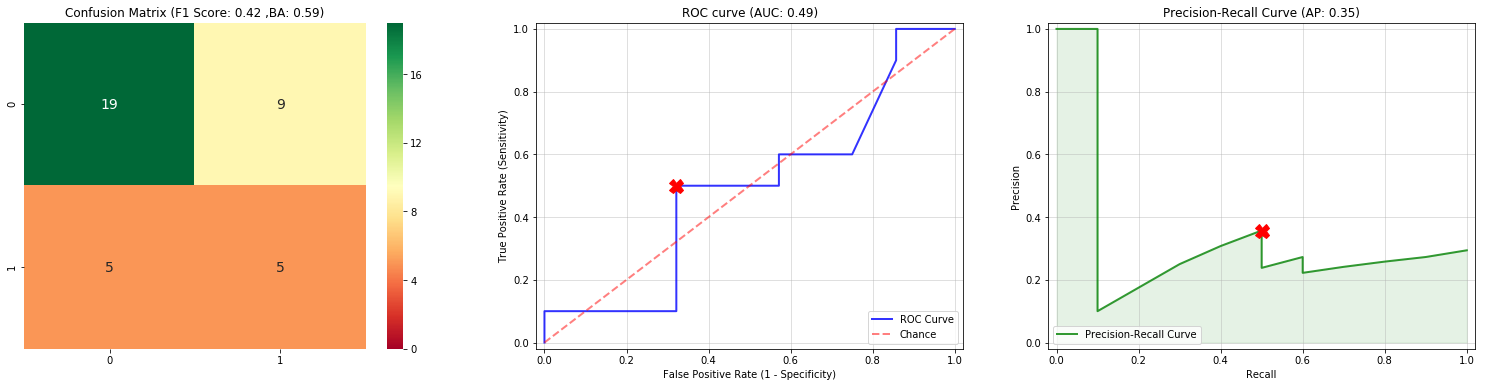

In [16]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['RandomForest'])

index_name = 'RandomForest_544'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'RandomForest', '544', 'None', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       1.00      0.46      0.63        28
     Fallers       0.40      1.00      0.57        10

   micro avg       0.61      0.61      0.61        38
   macro avg       0.70      0.73      0.60        38
weighted avg       0.84      0.61      0.62        38

ROC Area Under Curve: 0.61
Average Precision:    0.32
Balanced Accuracy:    0.73
F1 Score:             0.57
---  Results saved!  ---


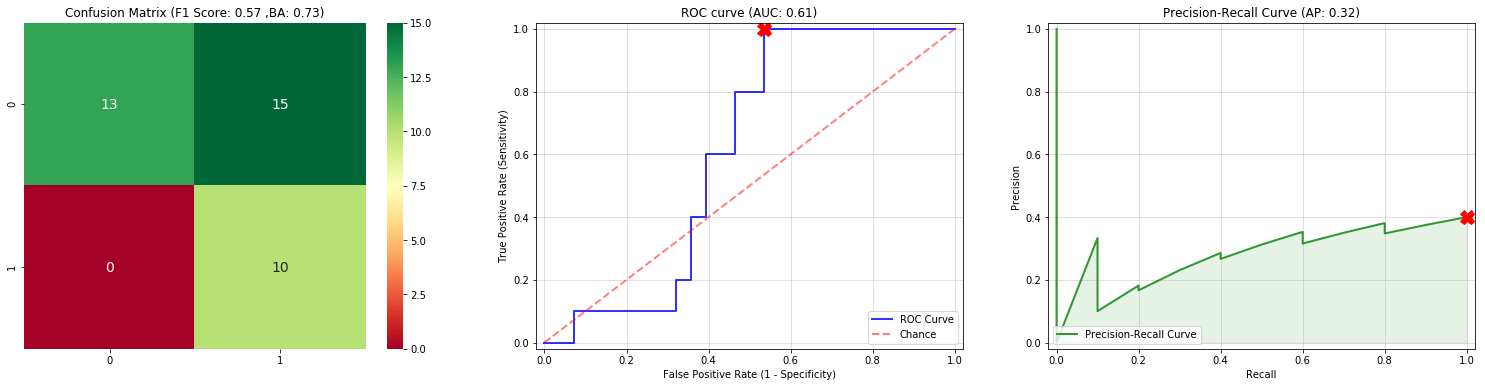

In [17]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_64'])

index_name = 'SVM_544_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'SVM', '544', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.89      0.61      0.72        28
     Fallers       0.42      0.80      0.55        10

   micro avg       0.66      0.66      0.66        38
   macro avg       0.66      0.70      0.64        38
weighted avg       0.77      0.66      0.68        38

ROC Area Under Curve: 0.66
Average Precision:    0.44
Balanced Accuracy:    0.7
F1 Score:             0.55
---  Results saved!  ---


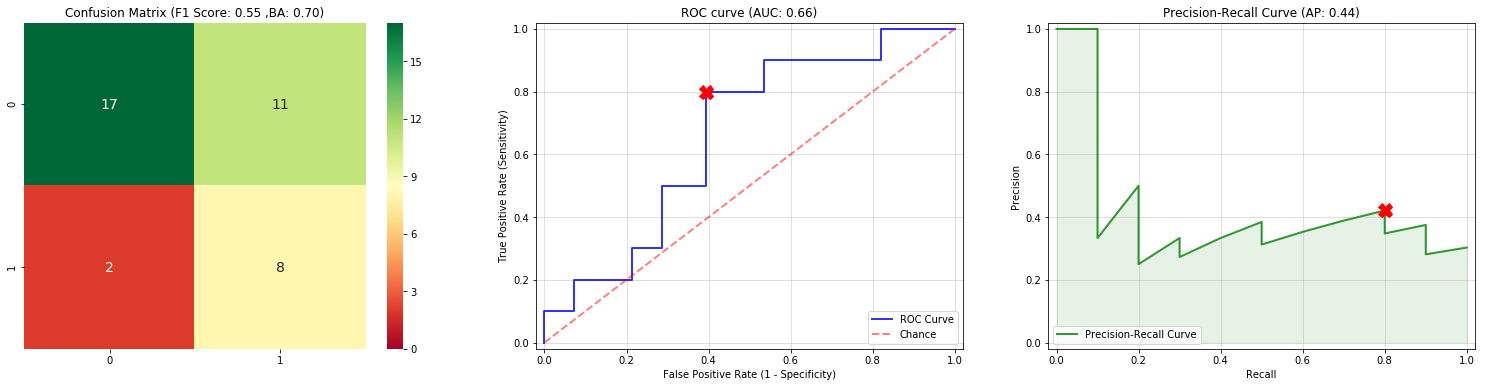

In [18]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_32'])

index_name = 'SVM_544_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'SVM', '544', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### SVM Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.81      0.75      0.78        28
     Fallers       0.42      0.50      0.45        10

   micro avg       0.68      0.68      0.68        38
   macro avg       0.61      0.62      0.62        38
weighted avg       0.70      0.68      0.69        38

ROC Area Under Curve: 0.54
Average Precision:    0.33
Balanced Accuracy:    0.62
F1 Score:             0.45
---  Results saved!  ---


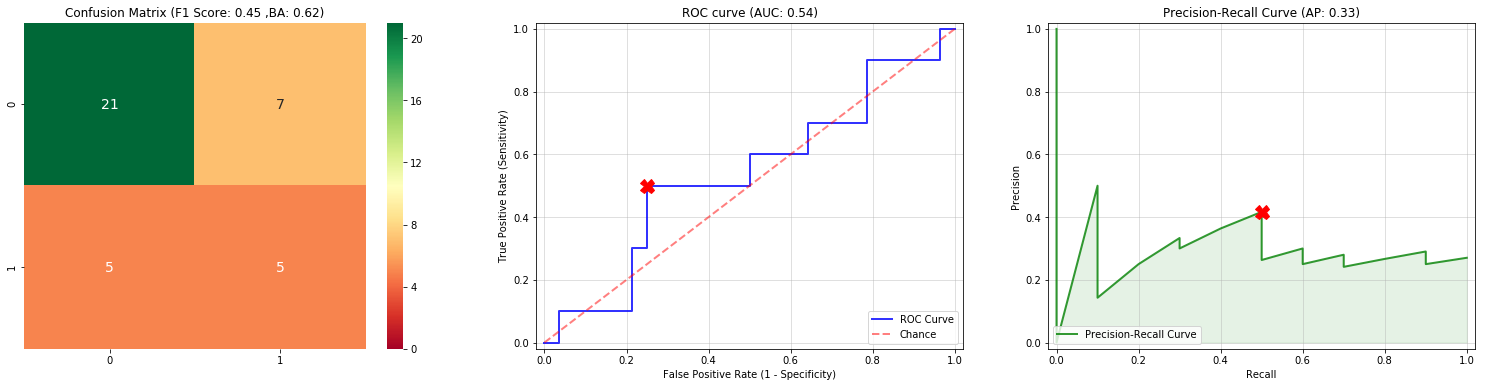

In [19]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['SVM_16'])

index_name = 'SVM_544_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'SVM', '544', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.76      0.68      0.72        28
     Fallers       0.31      0.40      0.35        10

   micro avg       0.61      0.61      0.61        38
   macro avg       0.53      0.54      0.53        38
weighted avg       0.64      0.61      0.62        38

ROC Area Under Curve: 0.41
Average Precision:    0.25
Balanced Accuracy:    0.54
F1 Score:             0.35
---  Results saved!  ---


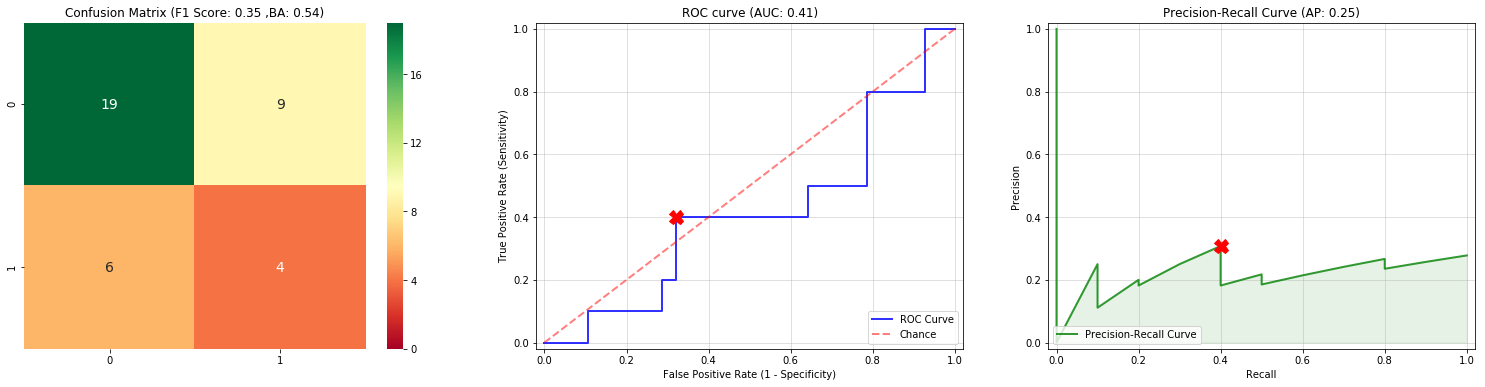

In [20]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_64'])

index_name = 'GradBoosting_544_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'GradientBoosting', '544', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.92      0.39      0.55        28
     Fallers       0.35      0.90      0.50        10

   micro avg       0.53      0.53      0.53        38
   macro avg       0.63      0.65      0.53        38
weighted avg       0.77      0.53      0.54        38

ROC Area Under Curve: 0.54
Average Precision:    0.31
Balanced Accuracy:    0.65
F1 Score:             0.5
---  Results saved!  ---


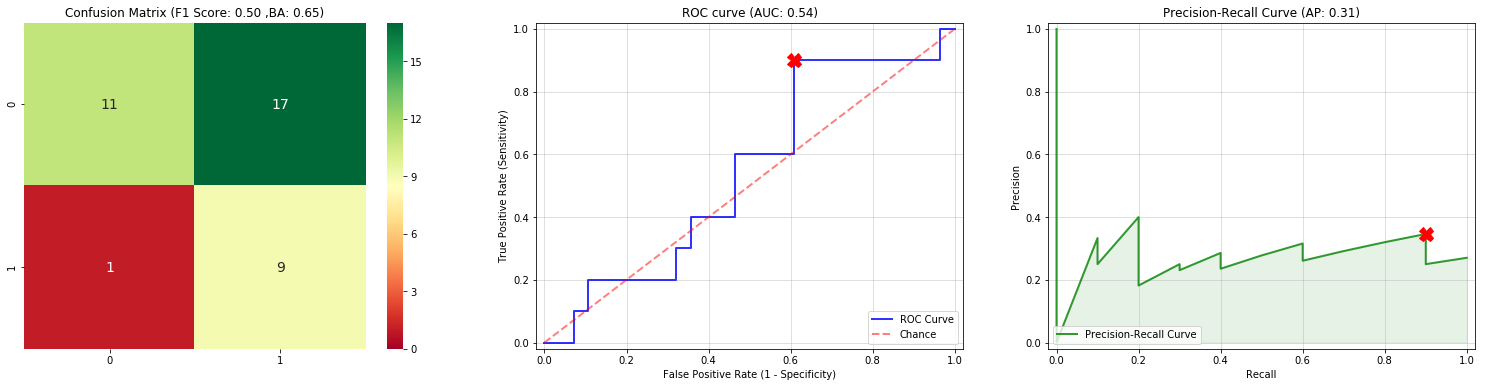

In [21]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_32'])

index_name = 'GradBoosting_544_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'GradientBoosting', '544', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### GradientBoosting Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.76      0.93      0.84        28
     Fallers       0.50      0.20      0.29        10

   micro avg       0.74      0.74      0.74        38
   macro avg       0.63      0.56      0.56        38
weighted avg       0.70      0.74      0.69        38

ROC Area Under Curve: 0.44
Average Precision:    0.36
Balanced Accuracy:    0.56
F1 Score:             0.29
---  Results saved!  ---


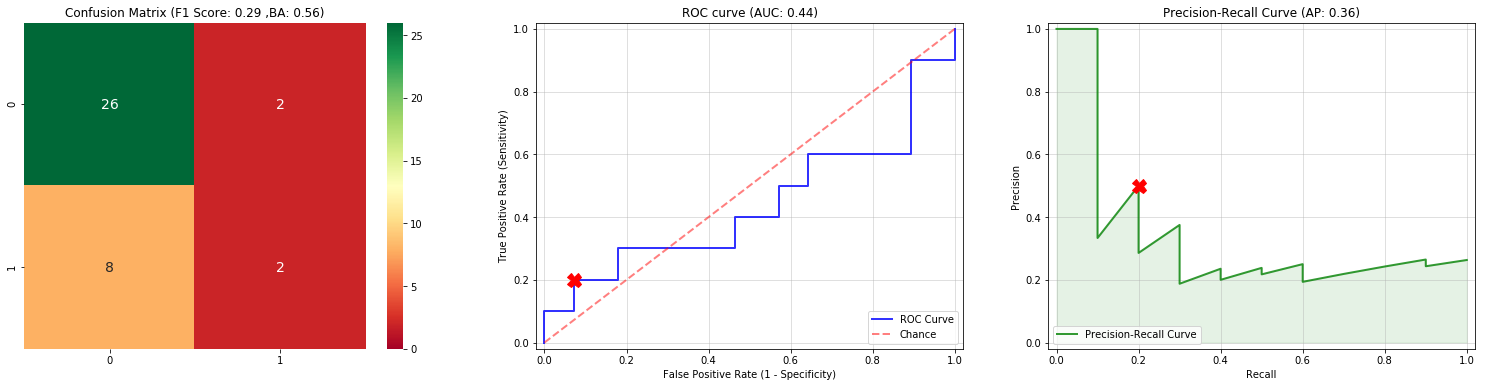

In [22]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['GradientBoosting_16'])

index_name = 'GradBoosting_544_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'GradientBoosting', '544', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 64 Components PCA

              precision    recall  f1-score   support

 Non Fallers       1.00      0.68      0.81        28
     Fallers       0.53      1.00      0.69        10

   micro avg       0.76      0.76      0.76        38
   macro avg       0.76      0.84      0.75        38
weighted avg       0.88      0.76      0.78        38

ROC Area Under Curve: 0.88
Average Precision:    0.71
Balanced Accuracy:    0.84
F1 Score:             0.69
---  Results saved!  ---


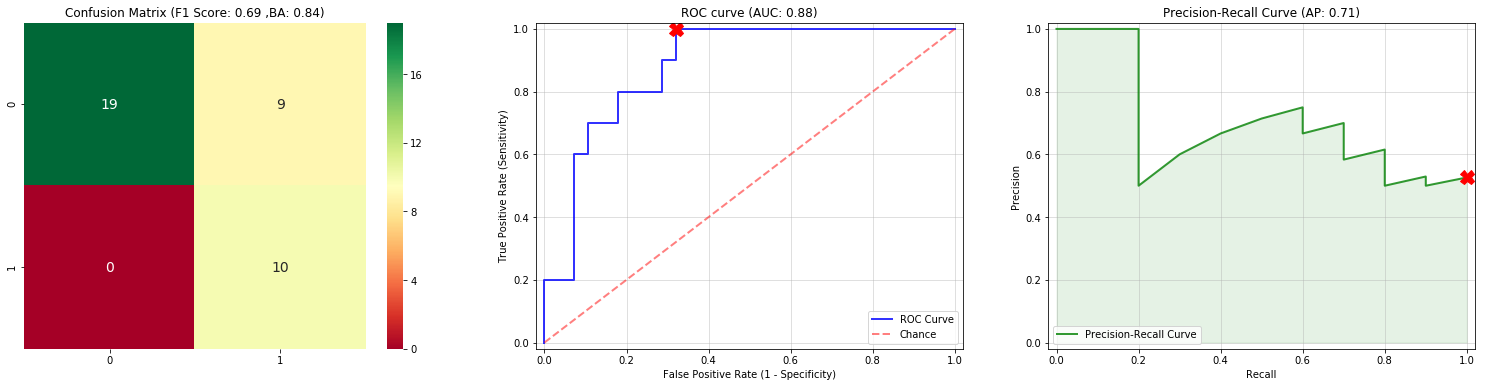

In [23]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_64'])

index_name = 'AdaBoosting_544_64'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'AdaBoosting', '544', '64', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 32 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.80      1.00      0.89        28
     Fallers       1.00      0.30      0.46        10

   micro avg       0.82      0.82      0.82        38
   macro avg       0.90      0.65      0.68        38
weighted avg       0.85      0.82      0.78        38

ROC Area Under Curve: 0.6
Average Precision:    0.53
Balanced Accuracy:    0.65
F1 Score:             0.46
---  Results saved!  ---


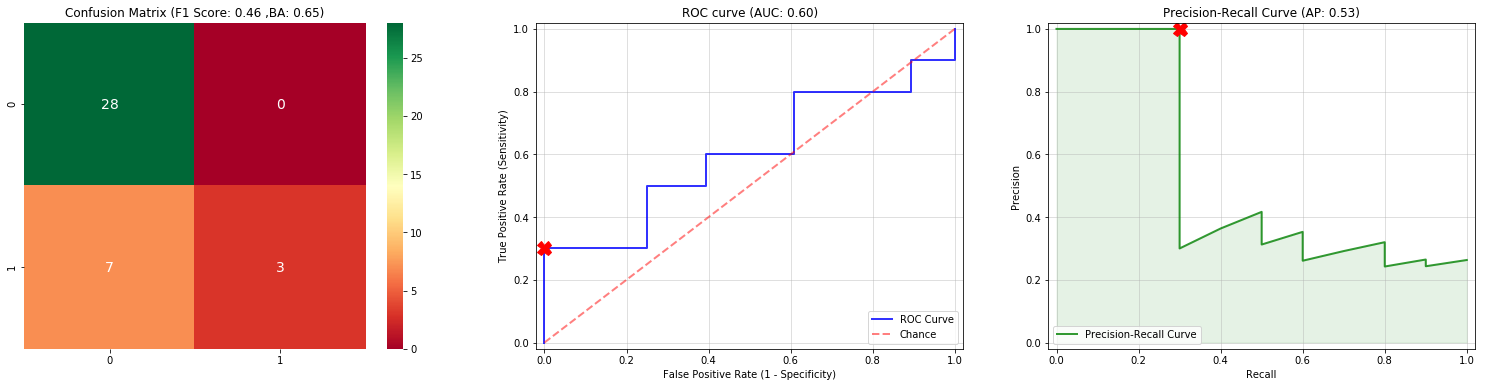

In [24]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_32'])

index_name = 'AdaBoosting_544_32'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'AdaBoosting', '544', '32', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')

### AdaBoosting Classifier on 16 Components PCA

              precision    recall  f1-score   support

 Non Fallers       0.77      0.86      0.81        28
     Fallers       0.43      0.30      0.35        10

   micro avg       0.71      0.71      0.71        38
   macro avg       0.60      0.58      0.58        38
weighted avg       0.68      0.71      0.69        38

ROC Area Under Curve: 0.46
Average Precision:    0.37
Balanced Accuracy:    0.58
F1 Score:             0.35
---  Results saved!  ---


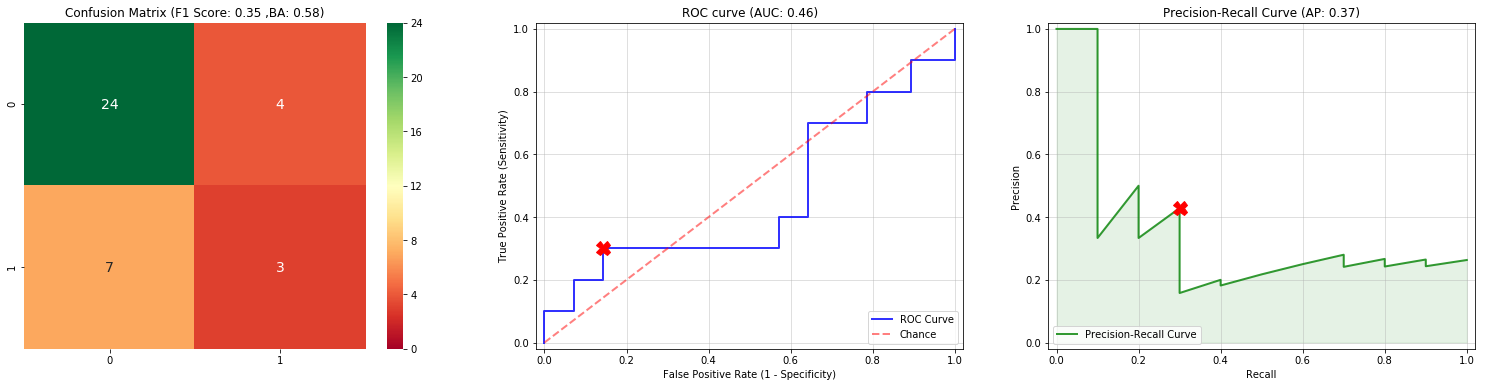

In [25]:
auc_score, average_precision, balanced_accuracy, F1_score = collect_and_print_results(results['AdaBoosting_16'])

index_name = 'AdaBoosting_544_16'
if index_name not in df_results.index or (auc_score + F1_score)/2 > (df_results.loc[index_name, 'AUC_Score'] + df_results.loc[index_name, 'F1_Score'])/2:
    df_results.loc[index_name, :] = ['Whole', 'AdaBoosting', '544', '16', auc_score, F1_score, average_precision, balanced_accuracy]
    plt.savefig(index_name + '.png', bbox_inches='tight')
    df_results.to_pickle("../results.pkl")
    print('---  Results saved!  ---')